## POS tagging using modified Viterbi

### Data Preparation

In [48]:
#Importing libraries
import nltk
import re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [49]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [50]:
#print first few tagged sentences
print(nltk_data[:50])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

### Build the vanilla Viterbi based POS tagger

In [51]:
# Splitting into train and test in the 95:5 ratio
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:50])

3718
196
[[('Several', 'ADJ'), ('traders', 'NOUN'), ('maintained', 'VERB'), ('that', 'ADP'), ('the', 'DET'), ('Merc', 'NOUN'), ("'s", 'PRT'), ('12-point', 'ADJ'), ('circuit-breaker', 'NOUN'), ('aggravated', 'VERB'), ('the', 'DET'), ('market', 'NOUN'), ('slide', 'NOUN'), ('Oct.', 'NOUN'), ('13', 'NUM'), ('by', 'ADP'), ('*-1', 'X'), ('directing', 'VERB'), ('additional', 'ADJ'), ('selling', 'VERB'), ('pressure', 'NOUN'), ('to', 'PRT'), ('the', 'DET'), ('floor', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('Stock', 'NOUN'), ('Exchange', 'NOUN'), ('.', '.')], [('The', 'DET'), ('remaining', 'VERB'), ('$', '.'), ('21.9', 'NUM'), ('billion', 'NUM'), ('*U*', 'X'), ('could', 'VERB'), ('be', 'VERB'), ('raised', 'VERB'), ('*-111', 'X'), ('through', 'ADP'), ('the', 'DET'), ('sale', 'NOUN'), ('of', 'ADP'), ('short-term', 'ADJ'), ('Treasury', 'NOUN'), ('bills', 'NOUN'), (',', '.'), ('two-year', 'ADJ'), ('notes', 'NOUN'), ('in', 'ADP'), ('November', 'NOUN'), ('and', 'CON

In [52]:
# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95669

In [53]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['Several',
 'traders',
 'maintained',
 'that',
 'the',
 'Merc',
 "'s",
 '12-point',
 'circuit-breaker',
 'aggravated']

In [54]:
# vocabulary
V = set(tokens)
print(len(V))

12078


In [55]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
len(T)

12

In [56]:
print(T)

{'ADP', 'ADJ', 'PRT', 'ADV', 'PRON', 'DET', 'NOUN', '.', 'NUM', 'CONJ', 'VERB', 'X'}


### Emission Probabilities

In [57]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [58]:
w_given_t

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [59]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)


In [60]:
# examples

# night
print("\n", "night")
print(word_given_tag('night', 'ADJ'))
print(word_given_tag('night', 'PRON'))
print(word_given_tag('night', 'NOUN'), "\n")

# was
print("\n", "was")
print(word_given_tag('was', 'ADJ'))
print(word_given_tag('was', 'NOUN'))
print(word_given_tag('was', 'VERB'))

# California
print("\n", "California")
print(word_given_tag('California', 'NOUN'))
print(word_given_tag('California', 'VERB'))


 night
(0, 6054)
(0, 2600)
(8, 27462) 


 was
(0, 6054)
(0, 27462)
(342, 12844)

 California
(26, 27462)
(0, 12844)


### Transition Probabilities

In [61]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [62]:
# examples
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1('NOUN', 'ADV'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('NOUN', 'VERB'))
print(t2_given_t1('.', 'NOUN'))
print(t2_given_t1('NOUN','.'))
print(t2_given_t1('PRON', 'PRON'))
print(t2_given_t1('VERB', 'NOUN'))

(4233, 6054)
(94, 3008)
(5288, 8271)
(1415, 12844)
(6615, 27462)
(2491, 11190)
(18, 2600)
(4015, 27462)


In [63]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('ADJ', '.'))


(1917, 11190)
(1001, 11190)
(2491, 11190)
(490, 11190)


In [64]:
print(t2_given_t1('VERB', 'NOUN'))


(4015, 27462)


In [65]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [66]:
tags_matrix

array([[1.67556033e-02, 1.06510140e-01, 1.38740661e-03, 1.34471720e-02,
        6.85165450e-02, 3.23372453e-01, 3.23052287e-01, 4.02347930e-02,
        6.26467466e-02, 8.53788690e-04, 8.53788666e-03, 3.46851647e-02],
       [7.71390796e-02, 6.65675551e-02, 1.04063433e-02, 4.79022134e-03,
        4.95540153e-04, 5.12058148e-03, 6.99207127e-01, 6.45853952e-02,
        2.11430453e-02, 1.71787255e-02, 1.22233238e-02, 2.11430453e-02],
       [2.03545634e-02, 8.53578448e-02, 1.64149702e-03, 1.01772817e-02,
        1.87130664e-02, 1.01444520e-01, 2.49507546e-01, 4.36638221e-02,
        5.64674996e-02, 2.29809596e-03, 3.97242278e-01, 1.31319761e-02],
       [1.18683510e-01, 1.28656909e-01, 1.49601065e-02, 7.91223422e-02,
        1.46276597e-02, 6.94813803e-02, 3.12500000e-02, 1.37632981e-01,
        3.15824486e-02, 6.98138308e-03, 3.44414890e-01, 2.26063821e-02],
       [2.38461532e-02, 7.38461539e-02, 1.26923081e-02, 3.50000001e-02,
        6.92307670e-03, 8.84615351e-03, 2.11538464e-01, 4.03

In [67]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [68]:
tags_df

,ADP,ADJ,PRT,ADV,PRON,DET,NOUN,.,NUM,CONJ,VERB,X
ADP,0.016756,0.106510,0.001387,0.013447,0.068517,0.323372,0.323052,0.040235,0.062647,0.000854,0.008538,0.034685
ADJ,0.077139,0.066568,0.010406,0.004790,0.000496,0.005121,0.699207,0.064585,0.021143,0.017179,0.012223,0.021143
PRT,0.020355,0.085358,0.001641,0.010177,0.018713,0.101445,0.249508,0.043664,0.056467,0.002298,0.397242,0.013132
ADV,0.118684,0.128657,0.014960,0.079122,0.014628,0.069481,0.031250,0.137633,0.031582,0.006981,0.344415,0.022606
PRON,0.023846,0.073846,0.012692,0.035000,0.006923,0.008846,0.211538,0.040385,0.006154,0.005385,0.484231,0.091154
DET,0.009551,0.204087,0.000242,0.011970,0.003748,0.005562,0.639342,0.018015,0.021884,0.000484,0.039778,0.045339
NOUN,0.177372,0.011835,0.044097,0.016896,0.004697,0.013218,0.264074,0.240878,0.009431,0.042786,0.146202,0.028512
.,0.091063,0.043789,0.002413,0.052636,0.065505,0.171314,0.222609,0.094281,0.081323,0.058356,0.089455,0.027167
NUM,0.035419,0.033058,0.027450,0.002952,0.001771,0.002952,0.352420,0.114522,0.186836,0.013577,0.018300,0.210744
CONJ,0.053020,0.118488,0.005071,0.054864,0.058091,0.114799,0.351775,0.035500,0.041955,0.000461,0.158137,0.007838


In [69]:
tags_df.loc['.', :]

ADP     0.091063
ADJ     0.043789
PRT     0.002413
ADV     0.052636
PRON    0.065505
DET     0.171314
NOUN    0.222609
.       0.094281
NUM     0.081323
CONJ    0.058356
VERB    0.089455
X       0.027167
Name: ., dtype: float32

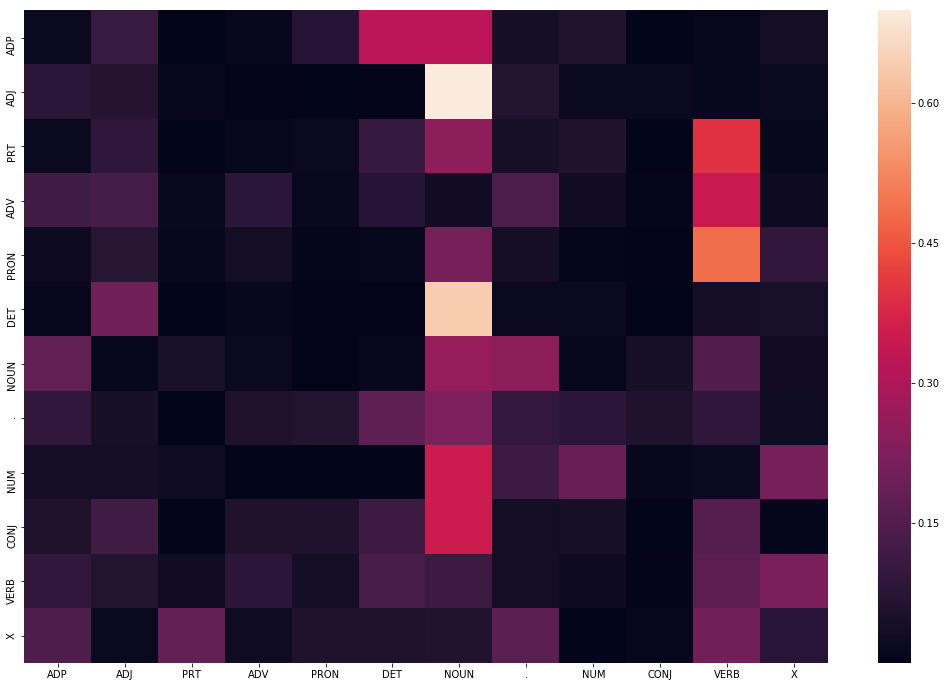

In [70]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

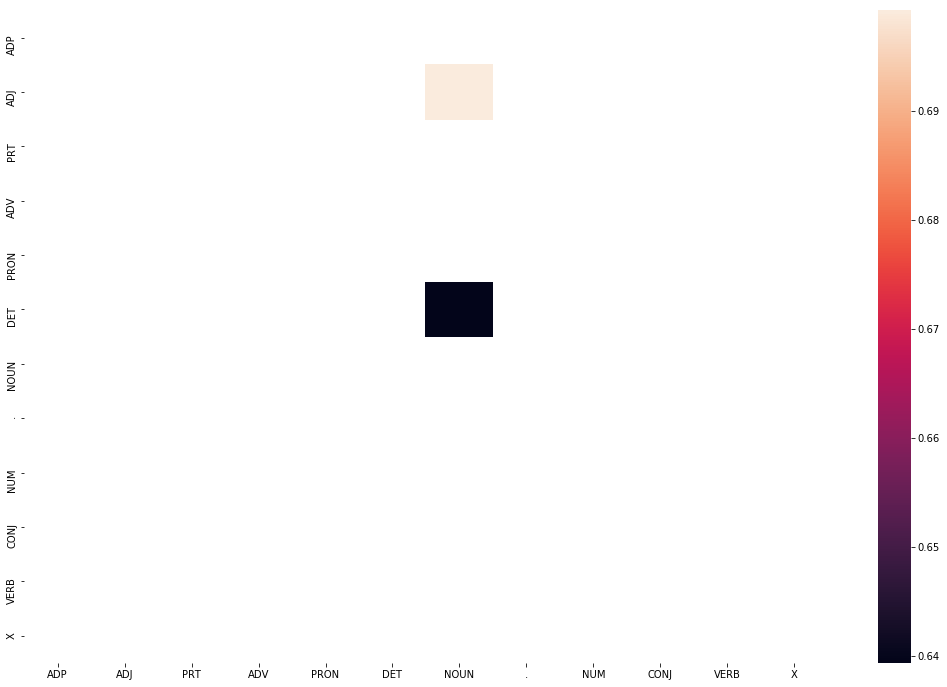

In [71]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [72]:
len(train_tagged_words)

95669

In [73]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [74]:
# list of sentences in the test set
test_run = [sent for sent in test_set]

# list of tagged words
test_run_base = [tup for sent in test_set for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]

In [75]:
print(len(test_run))
print(len(test_run_base))
print(len(test_tagged_words))

196
5007
5007


### Solve the problem of unknown words

#### Original viterbi algorithm fails if the test word is not available in the training corpus and it assigns the first tag to the unkonwn word.

### Viterbi Modification-Technique I 

-  #### We are modifying the base viterbi function to create a new function modified_Viterbi_1.
-  #### It first uses the vanilla viterbi algorithm logic to compute the tag of the word. If the maximum state probability for a word is 0, it calls a new funtion rule_based_tag to identify the tag of the word.
-  #### We pass the current word and the previous word to the rule_based_tag function. This function uses some predefined rules based on regular expression search patterns to identify the tag of the word.

In [118]:
# compute tag using predefined rules based on regular expression search patterns. 

def rule_based_tag(prev_word, word):
    
    #If the previous word is either - 'will','would','can',could','should','to' - then the tag of the current word is 'VERB'  
    if(prev_word in ['will','would','can','could','should','to']):
        tag = 'VERB'
    #If the word is completly numeric (including -ve and decimal signs) - then the tag of the word is 'NUM'
    elif(re.search('^-?[0-9]+(.[0-9]+)?$', word)):
        tag = 'NUM'
    #If the word has a hypen in the middle - then the tag of the word is 'ADJ', e.g. best-selling
    elif(re.search('.+-+.+', word)):
        tag = 'ADJ'
    #If the previous word is either - 'a', 'an' or 'the' and current word ends with 'ing', then tag of the current word is 'ADJ'
    elif(prev_word in ['a','an','the'] and re.search('.+ing$', word)):
        tag = 'ADJ'
    #If the word ends with either 'ing' or 'ed' or 'ould' - then the tag of the word is 'VERB'
    elif(re.search('.*(ing|ed|ould)$', word)):
        tag = 'VERB'
    #If the word starts with a capital letter - then the tag of the word is 'NOUN'
    elif(re.search('^[A-Z]+', word)):
        tag = 'NOUN'
    #If the word ends with 'ous' - then the tag of the word is 'ADJ'
    elif(re.search('.+(ous)$', word)):
        tag = 'ADJ'
    #If the word ends with 'ly' - then the tag of the word is 'ADV'
    elif(re.search('.+(ly)$', word)):
        tag = 'ADV'
    #If the word ends with 's' - then the tag of the word is 'NOUN'
    elif(re.search('.+s$', word)):
        tag = 'NOUN'
    #Assign the tag 'NOUN' if none of the above rule matches
    else:
        tag = 'NOUN'
    
    return (tag)

In [77]:
# Modified Viterbi Heuristic technique I
def modified_Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        word_tag = None
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        #if max state probability is 0, then call rule_based_tag function
        if pmax == 0:
            if key == 0:
                prev_word = '.'
            else:
                prev_word = words[key-1]
            
            word_tag = rule_based_tag(prev_word, word)
            state.append(word_tag)

        else:
            # getting state for which probability is maximum
            state_max = T[p.index(pmax)] 
            state.append(state_max)

    return list(zip(words, state))


### Viterbi Modification-Technique II

-  #### We are modifying the base viterbi function to create a new function modified_Viterbi_2.
-  #### This technique has three stages to compute the tag of the words. 
####        For each word:
 - #### Use the vanilla viterbi algorithm logic to compute the tag of the word. If the maximum state probability for the word is greater than 0, use the corresponding tag for the maximum state probability.
 - #### If the maximum state probability for the word is 0, then it calls the function tag_given_prev_next_words to compute the tag of the word. We pass previous word, tag of the previous word (since we have already computed the tag of the previous word) and the next word in the sequence to this function. We basically try to find similar words in the training corpus which has same previous word, previous tag and next word. tag_given_prev_next_words function finds all words in the training corpus which has same 1) previous word, 2) tag of the previous word, 3) next word. It then stores the tags of such similar words and their counts in a dictionary. The tag with maximum count (occurences) is returned by the function. If no matches occur, then None is returned by the function.
 - #### If tag_given_prev_next_words returns None, then it means that training corpus doesn't have any words with similar surrounding words. We then make a last attempt to compute the tag of the word. We calculate the state probabilities of the tags for the word again and this time if either of the transition or emission probabilities are zero, we assume them as 1 (so that we use only the other non-zero probability). We use the corresponding tag for the maximum state probability.


In [78]:
# compute tag given previous word, previous word tag, next word

def tag_given_prev_next_words(prev_word, prev_tag, next_word, train_bag = train_tagged_words):
    tags = {}
    for i in range(len(train_bag)-3):
        #if the ith word matches the previous word, tag of the ith word matches the tag of the previous word and 
        #(i+2) word matches the next word, then store the tag of the (i+1) word in the dictionary tags. (i+1) is the 
        #similar word to our given word (having same surrounding words)
        if(train_bag[i][0] == prev_word and train_bag[i][1] == prev_tag and train_bag[i+2][0] == next_word):
            #Store the tag of the (i+1) word in the tags dictionary as the key 
            #and count of same tag searches as the dictionary value 
            if(tags.get(train_bag[i+1][1]) == None):
                tags[train_bag[i+1][1]] = 1
            else:
                tags[train_bag[i+1][1]] = tags[train_bag[i+1][1]] + 1
    max_key = None
    #return the key (tag) of the tags dictionary which has the maximum value (tag search occurences)
    if(len(tags) > 0):
        max_key = max(tags, key=lambda k: tags[k])

    return (max_key)

In [156]:
# Modified Viterbi Heuristic technique II
def modified_Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        word_tag = None
        
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        
        #if max state probability is 0, then call tag_given_prev_next_words function
        if pmax == 0:
            if key == 0:
                prev_word = '.'
                prev_tag = '.'
            else:
                prev_word = words[key-1]
                prev_tag = state[-1]
            
            next_word = words[key+1]
            word_tag = tag_given_prev_next_words(prev_word, prev_tag, next_word)
                    
        if(word_tag != None):
            state.append(word_tag)
        elif (pmax == 0):
        #If tag_given_prev_next_words didn't return any tag and base viterbi also failed, then caclulate state probabilities 
        #one more time. Here, if either of the transition or emission probabilities are zero, we assume them as 1 
        #(so that we use only the other non-zero probability). We use the corresponding tag for the maximum state probability.
            p.clear()
            for tag in T:
                if key == 0:
                    transition_p = tags_df.loc['.', tag]
                else:
                    transition_p = tags_df.loc[state[-1], tag]

                # compute emission and state probabilities
                emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
                if emission_p == 0 and transition_p != 0:
                    emission_p = 1
                elif transition_p == 0 and emission_p != 0:
                    transition_p = 1
                state_probability = emission_p * transition_p    
                p.append(state_probability)
            pmax = max(p)
        
        if(word_tag == None):
            # getting state for which probability is maximum
            if(pmax != 0):
                state_max = T[p.index(pmax)]
            else:
                #Use default tag 'NOUN' if still pmax is 0
                state_max = 'NOUN'
            state.append(state_max)

    return list(zip(words, state))


#### Evaluating tagging accuracy

#### Run and evaluate taging accuracy of base vanilla Viterbi algorithm 

In [80]:
# tagging the test sentences
start = time.time()
tagged_seq_base = Viterbi(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  813.3114354610443


In [81]:
# accuracy
check = [i for i, j in zip(tagged_seq_base, test_run_base) if i == j] 

In [82]:
base_accuracy = len(check)/len(tagged_seq_base)

In [83]:
print('Accuracy of base vanilla Viterbi alogirthm: ', base_accuracy)

Accuracy of base vanilla Viterbi alogirthm:  0.901937287797084


#### Run and evaluate taging accuracy of modified Viterbi technique I 

In [128]:
# tagging the test sentences
start = time.time()
tagged_seq_1 = modified_Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  816.4512813091278


In [129]:
# accuracy
check_1 = [i for i, j in zip(tagged_seq_1, test_run_base) if i == j] 

In [130]:
accuracy_1 = len(check_1)/len(tagged_seq_1)

In [131]:
print('Accuracy of modified Viterbi technique I: ', accuracy_1)

Accuracy of modified Viterbi technique I:  0.9516676652686239


#### Run and evaluate taging accuracy of modified Viterbi technique II

In [152]:
# tagging the test sentences
start = time.time()
tagged_seq_2 = modified_Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start
print("Time taken in seconds: ", difference)

Time taken in seconds:  815.5191783905029


In [153]:
# accuracy
check_2 = [i for i, j in zip(tagged_seq_2, test_run_base) if i == j] 

In [154]:
accuracy_2 = len(check_2)/len(tagged_seq_base)

In [160]:
print('Accuracy of modified Viterbi technique II: ', accuracy_2)

Accuracy of modified Viterbi technique II:  0.961078290393449


### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### Taging accuracy of base vanilla Viterbi algorithm: 

In [159]:
print('Accuracy of base vanilla Viterbi alogirthm: ', base_accuracy)

Accuracy of base vanilla Viterbi alogirthm:  0.901937287797084


### Taging accuracy of modified Viterbi technique I

In [161]:
print('Accuracy of modified Viterbi technique I: ', accuracy_1)

Accuracy of modified Viterbi technique I:  0.9516676652686239


### Taging accuracy of modified Viterbi technique II

In [162]:
print('Accuracy of modified Viterbi technique II: ', accuracy_2)

Accuracy of modified Viterbi technique II:  0.961078290393449


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

In [98]:
#Read the file - Test_sentences.txt
text_file = open("Test_sentences.txt", "r")
lines = [line.rstrip('\n') for line in text_file]
text_file.close()

In [99]:
lines

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.",
 'Twitter is an online news and social networking service on which users post and interact with messages known as tweets.',
 'Before entering politics, Donald Trump was a domineering businessman and a television personality.',
 'The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.',
 'This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.',
 'Show me the cheapest round trips from Dallas to Atlanta',
 'I would like to see flights from Denver to Philadelphia.',
 'Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.',
 'NASA invited social media users to experienc

#### POS tagging of the first line in the file by base Viterbi algorithm

In [102]:
sentence_test = lines[0]
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)

print(tagged_seq)

[('Android', 'ADP'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'ADP'), ('.', '.')]


#### POS tagging of the first line in the file by modified Viterbi technique I

In [103]:
sentence_test = lines[0]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_1(words)

print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


#### POS tagging of the first line in the file by modified Viterbi Technique II

In [104]:
sentence_test = lines[0]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_2(words)

print(tagged_seq)

[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.')]


#### Incorrect POS tagging by base Viterbi: ('Android', 'ADP'), ('Google', 'ADP')
#### Correct POS tagging by modified Viterbi Technique I: ('Android', 'NOUN'), ('Google', 'NOUN')
#### Correct POS tagging by modified Viterbi Technique II: ('Android', 'NOUN'), ('Google', 'NOUN')

#### POS tagging of the second line in the file by base Viterbi algorithm

In [105]:
sentence_test = lines[1]
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)

print(tagged_seq)

[('Android', 'ADP'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'ADP'), ('worldwide', 'ADP'), ('on', 'ADP'), ('smartphones', 'ADP'), ('since', 'ADP'), ('2011', 'ADP'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'ADP'), ('.', '.')]


#### POS tagging of the second line in the file by modified Viterbi technique I

In [109]:
sentence_test = lines[1]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_1(words)

print(tagged_seq)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'ADJ'), ('on', 'ADP'), ('smartphones', 'NOUN'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


#### POS tagging of the second line in the file by modified Viterbi Technique II

In [107]:
sentence_test = lines[1]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_2(words)

print(tagged_seq)

[('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'DET'), ('since', 'ADP'), ('2011', 'DET'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.')]


#### Incorrect POS tagging by base Viterbi: ('Android', 'ADP'), ('OS', 'ADP'),  ('smartphones', 'ADP'), ('2011', 'ADP'), ('2013', 'ADP')
#### Correct POS tagging by modified Viterbi Technique I: ('Android', 'NOUN'), ('OS', 'NOUN'),  ('smartphones', 'NOUN'), ('2011', 'NUM'), ('2013', 'NUM')
#### Correct POS tagging by modified Viterbi Technique II: ('Android', 'NOUN'), ('OS', 'NOUN')

#### POS tagging of the third line in the file by base Viterbi algorithm

In [112]:
sentence_test = lines[2]
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)

print(tagged_seq)

[('Google', 'ADP'), ('and', 'CONJ'), ('Twitter', 'ADP'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('gave', 'VERB'), ('Google', 'ADP'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'ADP'), ("'s", 'PRT'), ('firehose', 'ADP'), ('.', '.')]


#### POS tagging of the third line in the file by modified Viterbi technique I

In [113]:
sentence_test = lines[2]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_1(words)

print(tagged_seq)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NUM'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'VERB'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


#### POS tagging of the third line in the file by modified Viterbi Technique II

In [114]:
sentence_test = lines[2]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_2(words)

print(tagged_seq)

[('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'NOUN'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'NOUN'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'NOUN'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'NOUN'), ("'s", 'PRT'), ('firehose', 'NOUN'), ('.', '.')]


#### Words with incorrect POS tagging by base Viterbi: ('Google', 'ADP'), ('Twitter', 'ADP'), ('2015', 'ADP'), ('that', 'DET'), ('Google', 'ADP'), ('Twitter', 'ADP'), ('firehose', 'ADP')
#### Words with correct POS tagging by modified Viterbi Technique I: ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('2015', 'NUM'), ('that', 'ADP'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('firehose', 'NOUN')
#### Words with correct POS tagging by modified Viterbi Technique II: ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('that', 'ADP'), ('Google', 'NOUN'), ('Twitter', 'NOUN'), ('firehose', 'NOUN')

#### POS tagging of the fourth line in the file by base Viterbi algorithm

In [122]:
sentence_test = lines[3]
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)

print(tagged_seq)

[('Twitter', 'ADP'), ('is', 'VERB'), ('an', 'DET'), ('online', 'ADP'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'ADP'), ('with', 'ADP'), ('messages', 'ADP'), ('known', 'ADJ'), ('as', 'ADP'), ('tweets', 'ADP'), ('.', '.')]


#### POS tagging of the fourth line in the file by modified Viterbi technique I

In [123]:
sentence_test = lines[3]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_1(words)

print(tagged_seq)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'NOUN'), ('with', 'ADP'), ('messages', 'NOUN'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


#### POS tagging of the fourth line in the file by modified Viterbi Technique II

In [124]:
sentence_test = lines[3]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_2(words)

print(tagged_seq)

[('Twitter', 'NOUN'), ('is', 'VERB'), ('an', 'DET'), ('online', 'NOUN'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CONJ'), ('interact', 'VERB'), ('with', 'ADP'), ('messages', 'DET'), ('known', 'VERB'), ('as', 'ADP'), ('tweets', 'NOUN'), ('.', '.')]


#### Words with incorrect POS tagging by base Viterbi: ('Twitter', 'ADP'), ('interact', 'ADP'), ('messages', 'ADP'), ('known', 'ADJ'), ('tweets', 'ADP')
#### Words with correct POS tagging by modified Viterbi Technique I: ('Twitter', 'NOUN'), ('messages', 'NOUN'), ('known', 'VERB'), ('tweets', 'NOUN')
#### Words with correct POS tagging by modified Viterbi Technique II:  ('Twitter', 'NOUN'), ('interact', 'VERB'), ('known', 'VERB'), ('tweets', 'NOUN')

#### POS tagging of the fifth line in the file by base Viterbi algorithm

In [125]:
sentence_test = lines[4]
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)

print(tagged_seq)

[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'ADP'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'ADP'), ('.', '.')]


#### POS tagging of the fifth line in the file by modified Viterbi technique I

In [126]:
sentence_test = lines[4]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_1(words)

print(tagged_seq)

[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'ADJ'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]


#### POS tagging of the fifth line in the file by modified Viterbi Technique II

In [127]:
sentence_test = lines[4]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_2(words)

print(tagged_seq)

[('Before', 'ADP'), ('entering', 'VERB'), ('politics', 'NOUN'), (',', '.'), ('Donald', 'NOUN'), ('Trump', 'NOUN'), ('was', 'VERB'), ('a', 'DET'), ('domineering', 'NOUN'), ('businessman', 'NOUN'), ('and', 'CONJ'), ('a', 'DET'), ('television', 'NOUN'), ('personality', 'NOUN'), ('.', '.')]


#### Words with incorrect POS tagging by base Viterbi: ('domineering', 'ADP'), ('personality', 'ADP')
#### Words with correct POS tagging by modified Viterbi Technique I: ('domineering', 'ADJ'), ('personality', 'NOUN')
#### Words with correct POS tagging by modified Viterbi Technique II: ('personality', 'NOUN')

#### POS tagging of the sixth line in the file by base Viterbi algorithm

In [136]:
sentence_test = lines[5]
words = word_tokenize(sentence_test)

tagged_seq = Viterbi(words)

print(tagged_seq)

[('The', 'DET'), ('2018', 'ADP'), ('FIFA', 'ADP'), ('World', 'NOUN'), ('Cup', 'ADP'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'ADP'), ('FIFA', 'ADP'), ('World', 'NOUN'), ('Cup', 'ADP'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'ADP'), ('contested', 'ADP'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


#### POS tagging of the sixth line in the file by modified Viterbi technique I

In [138]:
sentence_test = lines[5]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_1(words)

print(tagged_seq)

[('The', 'DET'), ('2018', 'NUM'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


#### POS tagging of the sixth line in the file by modified Viterbi Technique II

In [139]:
sentence_test = lines[5]
words = word_tokenize(sentence_test)

tagged_seq = modified_Viterbi_2(words)

print(tagged_seq)

[('The', 'DET'), ('2018', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), ('is', 'VERB'), ('the', 'DET'), ('21st', 'NOUN'), ('FIFA', 'NOUN'), ('World', 'NOUN'), ('Cup', 'NOUN'), (',', '.'), ('an', 'DET'), ('international', 'ADJ'), ('football', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'NOUN'), ('once', 'ADV'), ('every', 'DET'), ('four', 'NUM'), ('years', 'NOUN'), ('.', '.')]


#### Words with incorrect POS tagging by base Viterbi: ('2018', 'ADP'), ('FIFA', 'ADP'), ('Cup', 'ADP'), ('FIFA', 'ADP'), ('Cup', 'ADP'),  ('tournament', 'ADP'), ('contested', 'ADP')
#### Words with correct POS tagging by modified Viterbi Technique I: ('2018', 'NUM'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('tournament', 'NOUN'), ('contested', 'VERB')
#### Words with correct POS tagging by modified Viterbi Technique II: ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('FIFA', 'NOUN'), ('Cup', 'NOUN'), ('tournament', 'NOUN')